# WiDS Datathon 2023
Adapting to Climate Change by Improving Extreme Weather Forecasts

source : https://www.kaggle.com/competitions/widsdatathon2023

Main goal : forcast with the best accuracy the weather to help the people to anticipate their needs

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import uniform, randint
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import gc
import lightgbm as lgb
import optuna
%matplotlib inline
print("Libraries imported")

Libraries imported


## Reducing the memory usage of the dataset

In [2]:
cc_train = pd.read_csv('train_data.csv')
cc_test = pd.read_csv('test_data.csv')
cc_sample = pd.read_csv('sample_solution.csv')

In [3]:
def reduce_mem_usage(dataframe, verbose=True):
  numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
  start_memory = dataframe.memory_usage().sum() / 1024**2
  for col in dataframe.columns:
    col_type = dataframe[col].dtypes
    if col_type in numerics:
      c_min = dataframe[col].min()
      c_max = dataframe[col].max()
      if str(col_type)[:3] == 'int':
        if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
          dataframe[col] = dataframe[col].astype(np.int8)
        elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
          dataframe[col] = dataframe[col].astype(np.int16)
        elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
          dataframe[col] = dataframe[col].astype(np.int32)
        elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
          dataframe[col] = dataframe[col].astype(np.int64)
      else:
        if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
          dataframe[col] = dataframe[col].astype(np.float32)
        else:
          dataframe[col] = dataframe[col].astype(np.float64)
  end_memory = dataframe.memory_usage().sum() / 1024**2
  print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_memory, 100 * (start_memory - end_memory) / start_memory)) if verbose else print('Reduced to {:5.2f}'.format(end_memory))
  return dataframe

In [4]:


cc_train = reduce_mem_usage(cc_train)



Mem. usage decreased to 352.24 Mb (50.1% reduction)


### Overview of the dataset

In [5]:


cc_train.head()



,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,...,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20
0,0,0.0,0.833333,9/1/14,237.000000,29.02,31.639999,29.57,30.73,29.709999,...,-27.680000,-37.209999,8.32,9.560000,-2.03,48.130001,28.090000,-13.500000,11.90,4.58
1,1,0.0,0.833333,9/2/14,228.899994,29.02,31.639999,29.57,30.73,29.709999,...,-21.129999,-36.570000,8.77,21.170000,4.44,48.599998,27.410000,-23.770000,15.44,3.42
2,2,0.0,0.833333,9/3/14,220.690002,29.02,31.639999,29.57,30.73,29.709999,...,-10.720000,-34.160000,6.99,32.160000,5.01,48.529999,19.209999,-33.160000,15.11,4.82
3,3,0.0,0.833333,9/4/14,225.279999,29.02,31.639999,29.57,30.73,29.709999,...,0.330000,-31.040001,6.17,39.660000,-1.41,50.590000,8.290000,-37.220001,18.24,9.74
4,4,0.0,0.833333,9/5/14,237.240005,29.02,31.639999,29.57,30.73,29.709999,...,9.830000,-31.799999,7.47,38.619999,-5.21,54.730000,-2.580000,-42.299999,21.91,10.95


In [6]:


train_df = cc_train.copy()
test_df = cc_test.copy()



## Null values imputation

In [7]:
def filter_na_cols(df):
    count_na_df = df.isna().sum() 
    if count_na_df[count_na_df > 0].tolist():
        return count_na_df[count_na_df > 0]
    else:
        return 'Clean dataset'

In [8]:
na_cols = [
    'nmme0-tmp2m-34w__ccsm30',
    'nmme-tmp2m-56w__ccsm3',
    'nmme-prate-34w__ccsm3',
    'nmme0-prate-56w__ccsm30',
    'nmme0-prate-34w__ccsm30',
    'nmme-prate-56w__ccsm3',
    'nmme-tmp2m-34w__ccsm3',
    'ccsm30'
]

In [9]:
g_1 = ['nmme0-tmp2m-34w__cancm30',
'nmme0-tmp2m-34w__cancm40',
'nmme0-tmp2m-34w__ccsm30',
'nmme0-tmp2m-34w__ccsm40',
'nmme0-tmp2m-34w__cfsv20',
'nmme0-tmp2m-34w__gfdlflora0',
'nmme0-tmp2m-34w__gfdlflorb0',
'nmme0-tmp2m-34w__gfdl0',
'nmme0-tmp2m-34w__nasa0']

cc_train[g_1].mean(1)

0         30.454445
1         30.454445
2         30.454445
3         30.454445
4         30.454445
            ...    
375729    22.551111
375730    22.551111
375731    22.551111
375732    22.551111
375733    22.551111
Length: 375734, dtype: float32

In [10]:


cc_train['nmme0-tmp2m-34w__nmme0mean']



0         30.459999
1         30.459999
2         30.459999
3         30.459999
4         30.459999
            ...    
375729    22.549999
375730    22.549999
375731    22.549999
375732    22.549999
375733    22.549999
Name: nmme0-tmp2m-34w__nmme0mean, Length: 375734, dtype: float32

In [11]:
col_na = [
    'nmme0-tmp2m-34w__ccsm30', 
    'nmme-tmp2m-56w__ccsm3', 
    'nmme-prate-34w__ccsm3', 
    'nmme0-prate-56w__ccsm30', 
    'nmme0-prate-34w__ccsm30', 
    'nmme-prate-56w__ccsm3', 
    'nmme-tmp2m-34w__ccsm3',
    'ccsm30']

g_means =  ['nmme0-tmp2m-34w__nmme0mean', 
 'nmme-tmp2m-56w__nmmemean', 
 'nmme-prate-34w__nmmemean', 
 'nmme0-prate-56w__nmme0mean', 
 'nmme0-prate-34w__nmme0mean', 
 'nmme-prate-56w__nmmemean', 
 'nmme-tmp2m-34w__nmmemean',
 'nmme0mean']


g_1 = ['nmme0-tmp2m-34w__cancm30',
'nmme0-tmp2m-34w__cancm40',
'nmme0-tmp2m-34w__ccsm40',
'nmme0-tmp2m-34w__cfsv20',
'nmme0-tmp2m-34w__gfdlflora0',
'nmme0-tmp2m-34w__gfdlflorb0',
'nmme0-tmp2m-34w__gfdl0',
'nmme0-tmp2m-34w__nasa0']

g_2 = ['nmme-tmp2m-56w__cancm3',
'nmme-tmp2m-56w__cancm4',
'nmme-tmp2m-56w__ccsm4',
'nmme-tmp2m-56w__cfsv2',
'nmme-tmp2m-56w__gfdl',
'nmme-tmp2m-56w__gfdlflora',
'nmme-tmp2m-56w__gfdlflorb',
'nmme-tmp2m-56w__nasa']

g_3 = ['nmme-prate-34w__cancm3',
'nmme-prate-34w__cancm4',
'nmme-prate-34w__ccsm4',
'nmme-prate-34w__cfsv2',
'nmme-prate-34w__gfdl',
'nmme-prate-34w__gfdlflora',
'nmme-prate-34w__gfdlflorb',
'nmme-prate-34w__nasa']

g_4 = [ 'nmme0-prate-56w__cancm30',
'nmme0-prate-56w__cancm40',
'nmme0-prate-56w__ccsm40',
'nmme0-prate-56w__cfsv20',
'nmme0-prate-56w__gfdlflora0',
'nmme0-prate-56w__gfdlflorb0',
'nmme0-prate-56w__gfdl0',
'nmme0-prate-56w__nasa0']

g_5 = ['nmme0-prate-34w__cancm30',
'nmme0-prate-34w__cancm40',
'nmme0-prate-34w__ccsm40',
'nmme0-prate-34w__cfsv20',
'nmme0-prate-34w__gfdlflora0',
'nmme0-prate-34w__gfdlflorb0',
'nmme0-prate-34w__gfdl0',
'nmme0-prate-34w__nasa0']

g_6 = ['nmme-prate-56w__cancm3',
'nmme-prate-56w__cancm4',
'nmme-prate-56w__ccsm4',
'nmme-prate-56w__cfsv2',
'nmme-prate-56w__gfdl',
'nmme-prate-56w__gfdlflora',
'nmme-prate-56w__gfdlflorb',
'nmme-prate-56w__nasa']

g_7 = ['nmme-tmp2m-34w__cancm3',
'nmme-tmp2m-34w__cancm4',
'nmme-tmp2m-34w__ccsm4',
'nmme-tmp2m-34w__cfsv2',
'nmme-tmp2m-34w__gfdl',
'nmme-tmp2m-34w__gfdlflora',
'nmme-tmp2m-34w__gfdlflorb',
'nmme-tmp2m-34w__nasa']

g_8 = ['cancm30',    
'cancm40',    
'ccsm40',    
'cfsv20',    
'gfdlflora0',    
'gfdlflorb0',    
'gfdl0',    
'nasa0']

In [12]:


from tqdm.notebook import tqdm
gs = [g_1, g_2, g_3, g_4, g_5, g_6, g_7, g_8]

zip_cols = zip(col_na, gs, g_means)
for c, g, m in tqdm(zip_cols):
    cc_train[c] = (cc_train[m]*9) - cc_train[g].sum(1)



0it [00:00, ?it/s]

In [13]:


filter_na_cols(cc_train)



'Clean dataset'

## Visualise the time gap between the train and the test data

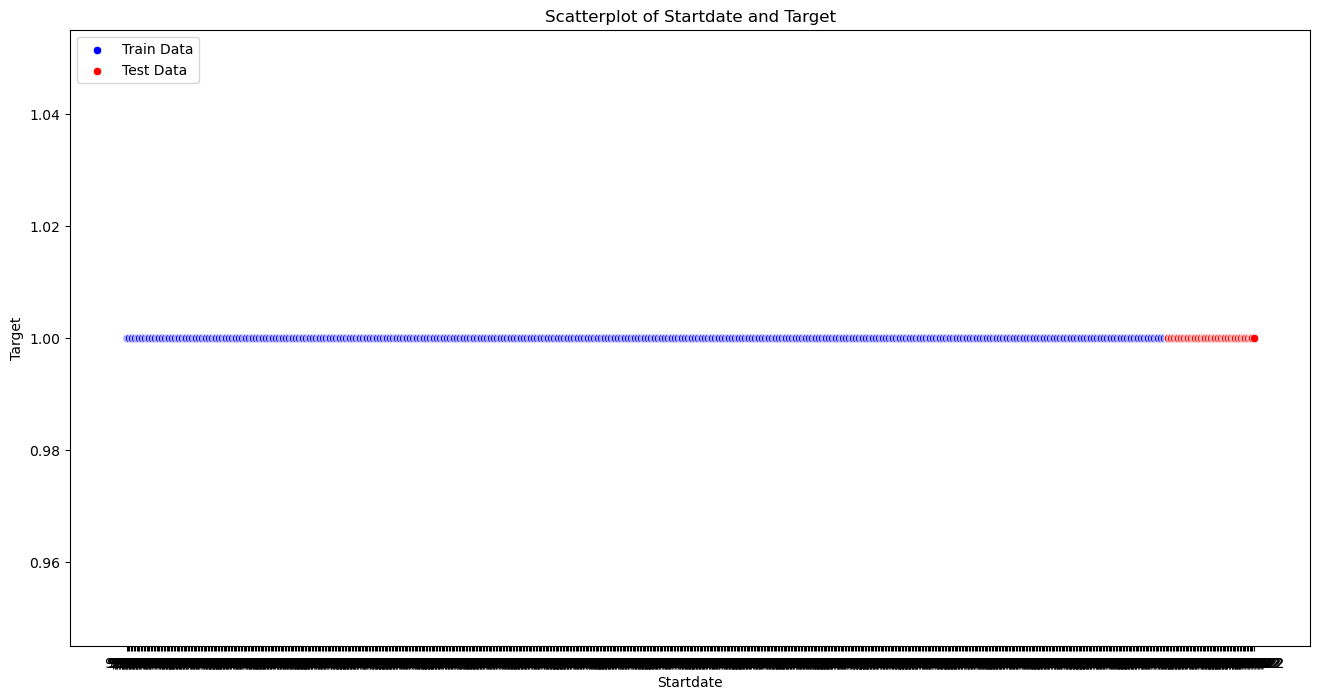

In [14]:
# create a scatterplot using seaborn and matplotlib
fig, ax = plt.subplots(figsize=(16, 8))
sb.scatterplot(x=train_df.startdate, y=1, color='blue', label='Train Data', ax=ax)
sb.scatterplot(x=test_df.startdate, y=1, color='red', label='Test Data', ax=ax)

# add labels and a title to the plot
ax.set_title('Scatterplot of Startdate and Target')
ax.set_xlabel('Startdate')
ax.set_ylabel('Target')
ax.legend(loc='upper left')

# display the plot
plt.show()



Based on the graph above the train data was from 2014 - 2016 and the test data is from 2022. There is a big time gap between the train and test data.


## Analyising the distribution of values in both the train and test dataset

<Figure size 1600x500 with 0 Axes>

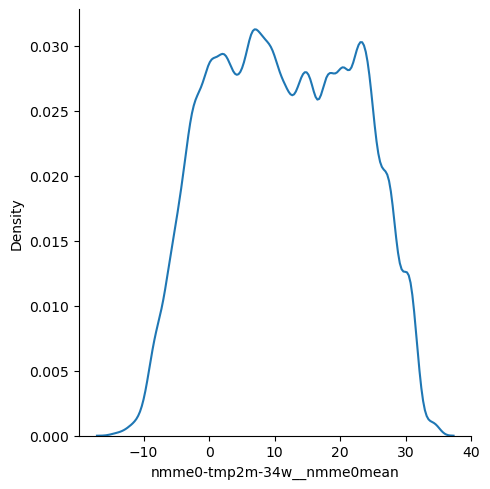

<Figure size 1600x500 with 0 Axes>

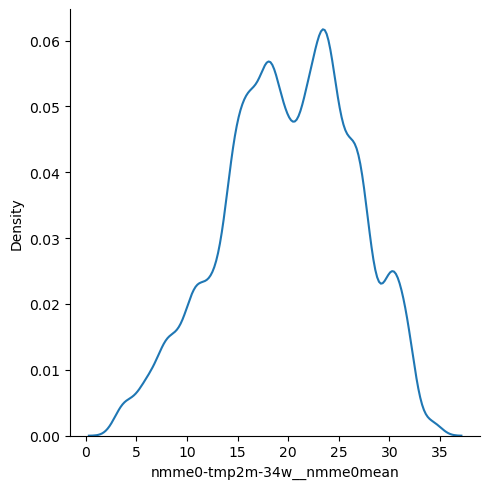

In [15]:
def dist_of_train_test_features(train_df, test_df, feature):
    # Analyse the distribution of values in the training dataset
    plt.figure(figsize=(16, 5))
    sb.displot(data=train_df, x=feature, kind='kde', label='Train Data')

    # Analyse the distribution of values in the testing dataset
    plt.figure(figsize=(16, 5))
    sb.displot(data=test_df, x=feature, kind='kde', label='Test Data')
dist_of_train_test_features(train_df, test_df, 'nmme0-tmp2m-34w__nmme0mean')

In [16]:


cc_train.shape



(375734, 246)

In [17]:


cc_train.describe()



,index,lat,lon,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,...,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20
count,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,...,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000
mean,187866.500000,0.592766,0.517964,276.744049,10.801681,12.726736,10.716890,11.638229,10.733886,11.772648,...,-1.209959,-8.109917,6.800684,19.251972,-17.697563,-9.846868,-6.231860,16.014360,10.489945,11.296336
std,108465.207359,0.251744,0.271945,198.077499,10.951795,11.072930,10.566621,10.573793,9.403106,10.689975,...,37.316212,36.204590,38.456974,25.287085,31.944239,34.161930,27.048275,25.846542,25.068645,25.112333
min,0.000000,0.000000,0.000000,-2.310000,-14.960000,-14.970000,-11.689987,-17.559999,-13.720000,-13.330000,...,-94.570000,-89.940002,-64.870003,-39.279999,-100.559998,-106.080002,-93.980003,-52.610001,-66.110001,-57.610001
25%,93933.250000,0.409091,0.300000,104.062498,1.550000,3.650000,1.980000,3.080000,3.390000,2.970000,...,-27.200001,-33.349998,-19.650000,1.960000,-40.029999,-32.169998,-20.170000,-0.360000,-6.790000,-5.570000
50%,187866.500000,0.590909,0.533333,250.320007,9.950000,11.890000,10.330009,11.600000,10.890000,11.280000,...,-3.200000,-9.390000,2.330000,20.049999,-16.709999,-8.560000,-6.030000,18.650000,11.860000,11.650000
75%,281799.750000,0.818182,0.766667,420.010010,20.230000,22.110001,19.669998,20.360001,18.330000,20.299999,...,24.940001,17.959999,28.660000,35.090000,4.390000,10.500000,11.630000,31.209999,29.040001,29.180000
max,375733.000000,1.000000,1.000000,1185.140015,36.080002,36.029999,34.730011,34.639999,35.750000,38.349998,...,113.919998,96.550003,106.419998,91.760002,56.549999,83.889999,64.849998,90.389999,76.889999,88.660004


In [18]:
cc_test.shape

(31354, 245)

In [19]:
cc_sample.describe()

,contest-tmp2m-14d__tmp2m,index
count,31354.000000,31354.000000
mean,25.006322,391410.500000
std,2.891139,9051.264507
min,20.000011,375734.000000
25%,22.503063,383572.250000
50%,25.030905,391410.500000
75%,27.511672,399248.750000
max,29.997898,407087.000000


## Visualizing the target variable

contest-tmp2m-14d__tmp2m

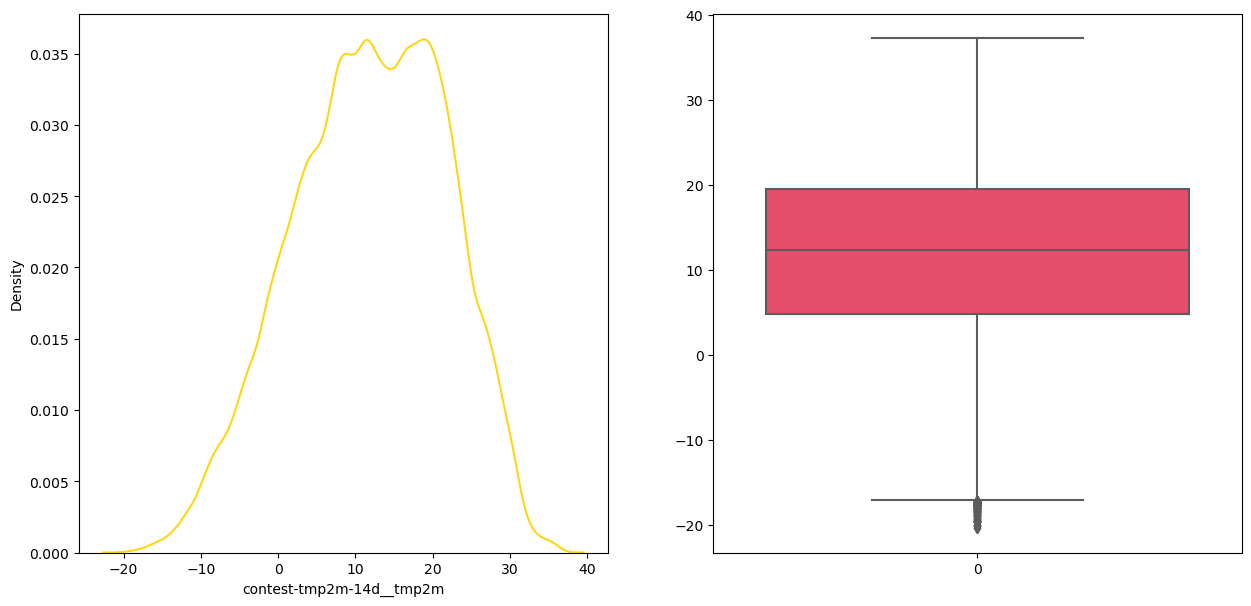

In [20]:
def target_var_visualized():
  plt.figure(figsize=(15,7))
  plt.subplot(121)
  sb.kdeplot(cc_train['contest-tmp2m-14d__tmp2m'], color = "#ffd514")
  plt.subplot(122)
  sb.boxplot(data=cc_train['contest-tmp2m-14d__tmp2m'], color = "#ff355d")
target_var_visualized()


Displaying the distribution of the target variable in the train and test

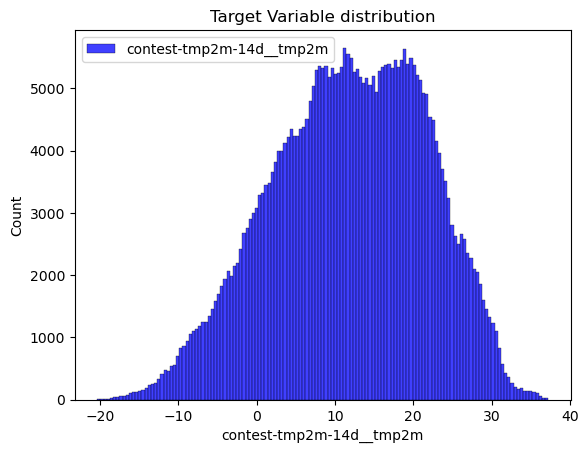

In [21]:
def histogram_plot(data, label, title):
    sb.histplot(data, color='blue', label=label)
    plt.legend()
    plt.title(title)
    plt.show()
histogram_plot(data=cc_train['contest-tmp2m-14d__tmp2m'], label="contest-tmp2m-14d__tmp2m", title="Target Variable distribution")



The target variable is not in the test dataset


### Simple for loop to list out the features from the train dataset

In [22]:
test_col = cc_test.columns
count = 0
for name in test_col:
  if count % 50 == 0:
    print()
  print(name + ', ', end='')
  count += 1


index, lat, lon, startdate, contest-pevpr-sfc-gauss-14d__pevpr, nmme0-tmp2m-34w__cancm30, nmme0-tmp2m-34w__cancm40, nmme0-tmp2m-34w__ccsm30, nmme0-tmp2m-34w__ccsm40, nmme0-tmp2m-34w__cfsv20, nmme0-tmp2m-34w__gfdlflora0, nmme0-tmp2m-34w__gfdlflorb0, nmme0-tmp2m-34w__gfdl0, nmme0-tmp2m-34w__nasa0, nmme0-tmp2m-34w__nmme0mean, contest-wind-h10-14d__wind-hgt-10, nmme-tmp2m-56w__cancm3, nmme-tmp2m-56w__cancm4, nmme-tmp2m-56w__ccsm3, nmme-tmp2m-56w__ccsm4, nmme-tmp2m-56w__cfsv2, nmme-tmp2m-56w__gfdl, nmme-tmp2m-56w__gfdlflora, nmme-tmp2m-56w__gfdlflorb, nmme-tmp2m-56w__nasa, nmme-tmp2m-56w__nmmemean, contest-rhum-sig995-14d__rhum, nmme-prate-34w__cancm3, nmme-prate-34w__cancm4, nmme-prate-34w__ccsm3, nmme-prate-34w__ccsm4, nmme-prate-34w__cfsv2, nmme-prate-34w__gfdl, nmme-prate-34w__gfdlflora, nmme-prate-34w__gfdlflorb, nmme-prate-34w__nasa, nmme-prate-34w__nmmemean, contest-wind-h100-14d__wind-hgt-100, nmme0-prate-56w__cancm30, nmme0-prate-56w__cancm40, nmme0-prate-56w__ccsm30, nmme0-prate-

In [23]:
cc_train.columns[cc_train.isna().any()].tolist()

[]

In [24]:


cc_test.columns[cc_test.isna().any()].tolist()



[]

In [25]:
cc_sample.columns[cc_sample.isna().any()].tolist()

[]

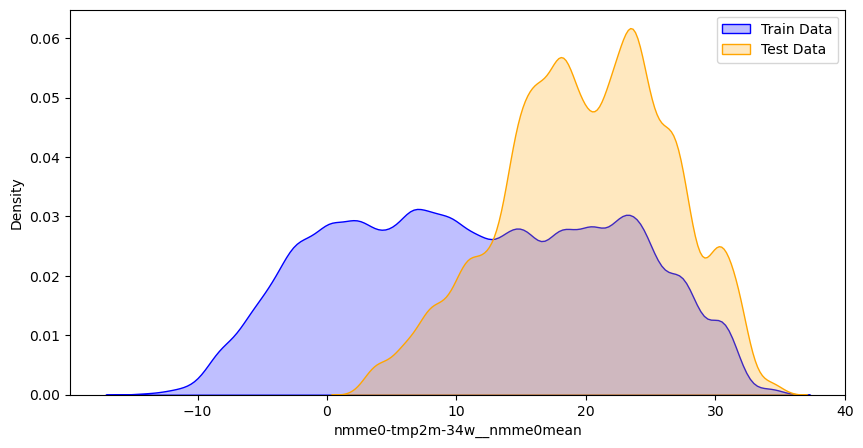

In [26]:
def train_test_dist(train, test):
    fig, ax = plt.subplots(figsize = (10, 5))
    sb.kdeplot(data=train,  color='blue', fill=True, ax=ax, label="Train Data")
    sb.kdeplot(data=test, color='orange', fill=True, ax=ax, label="Test Data")
    plt.legend()
    plt.show()
    
#train_target = cc_train['contest-tmp2m-14d__tmp2m']
#test_target = cc_test['contest-tmp2m-14d__tmp2m']
train_target = cc_train['nmme0-tmp2m-34w__nmme0mean']
test_target = cc_test['nmme0-tmp2m-34w__nmme0mean']
train_test_dist(train_target, test_target)

### Visualising Categorical columns

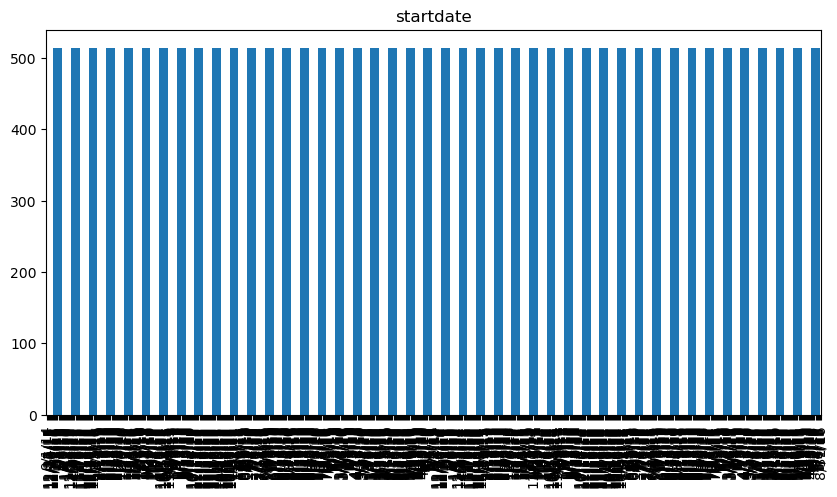

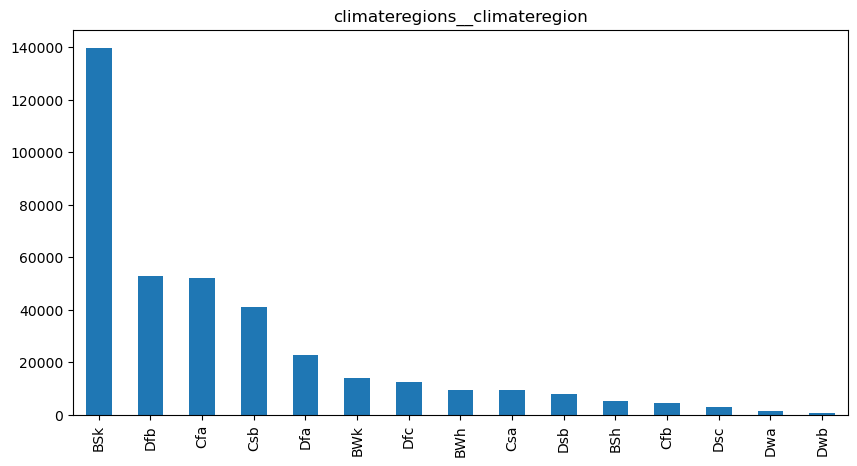

In [27]:
# Plot bar plots for all categorical columns
for column in cc_train.select_dtypes(include=['object']).columns:
    cc_train[column].value_counts().plot(kind='bar', figsize=(10,5))
    plt.title(column)
    plt.show()

## Visualising Numerical Columns

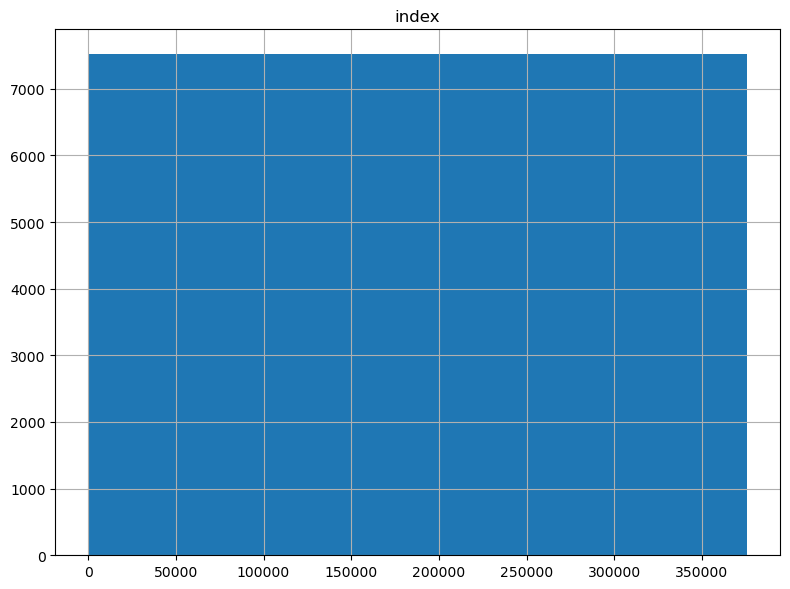

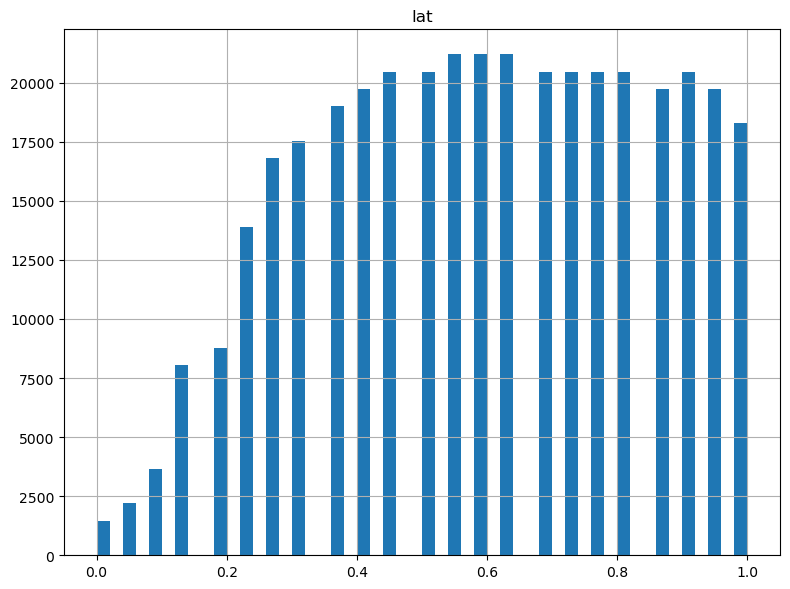

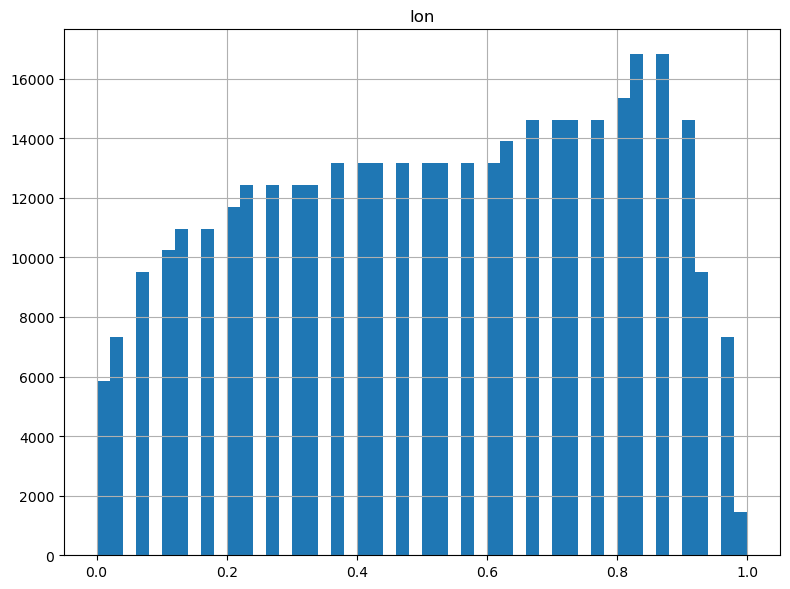

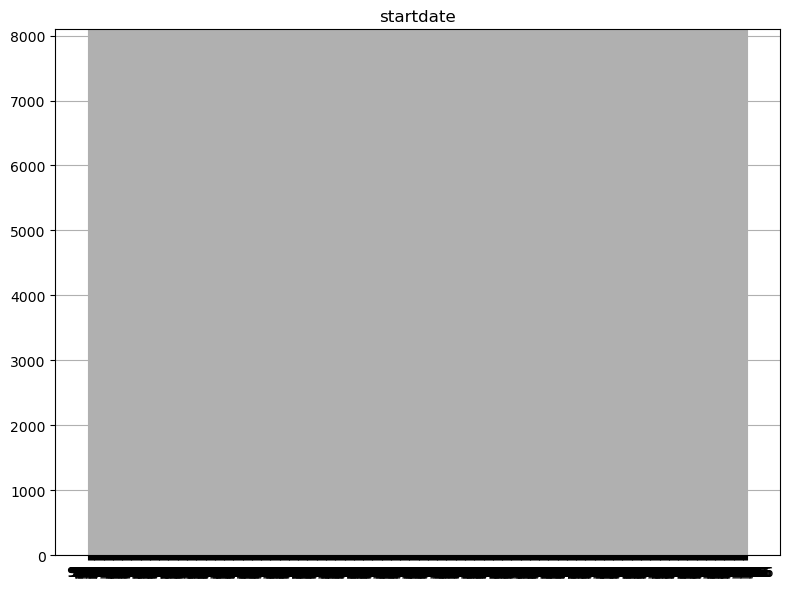

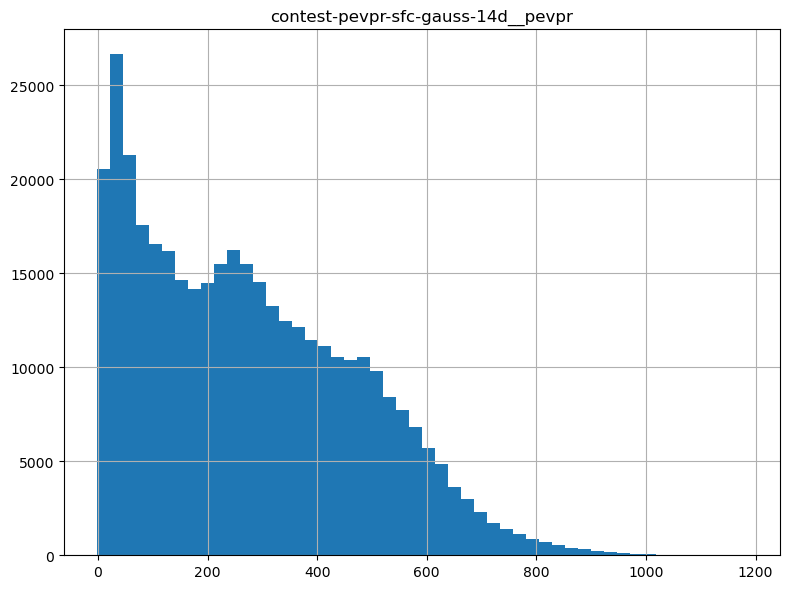

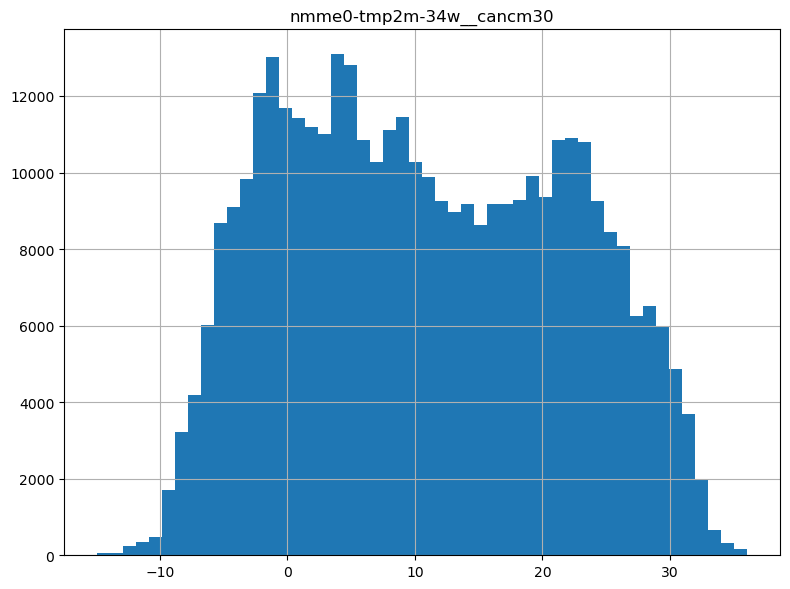

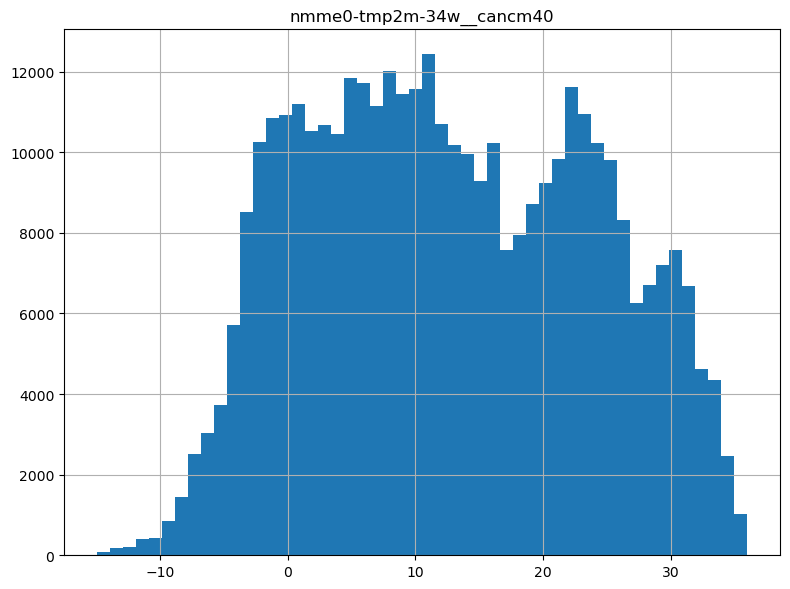

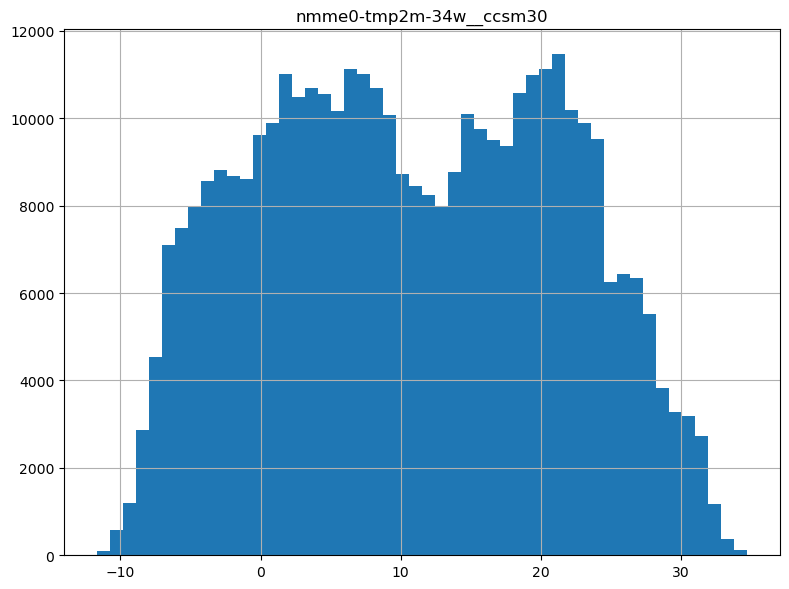

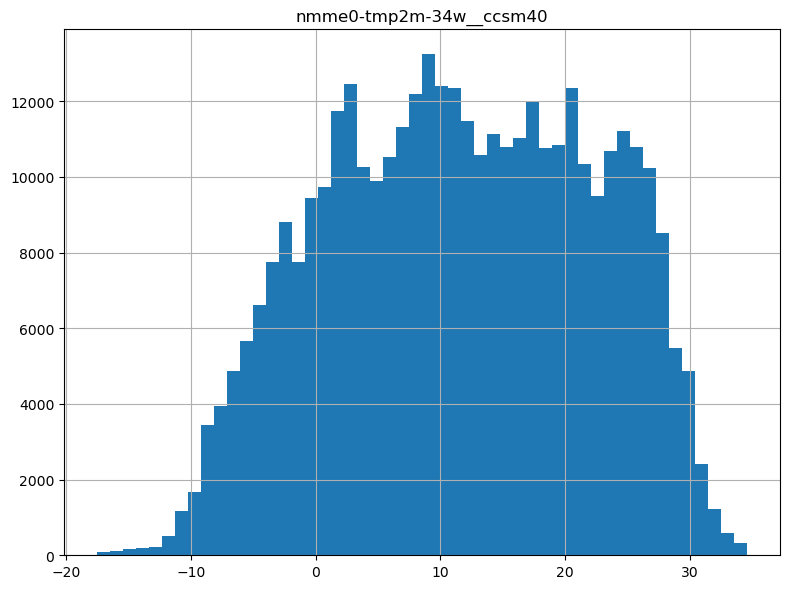

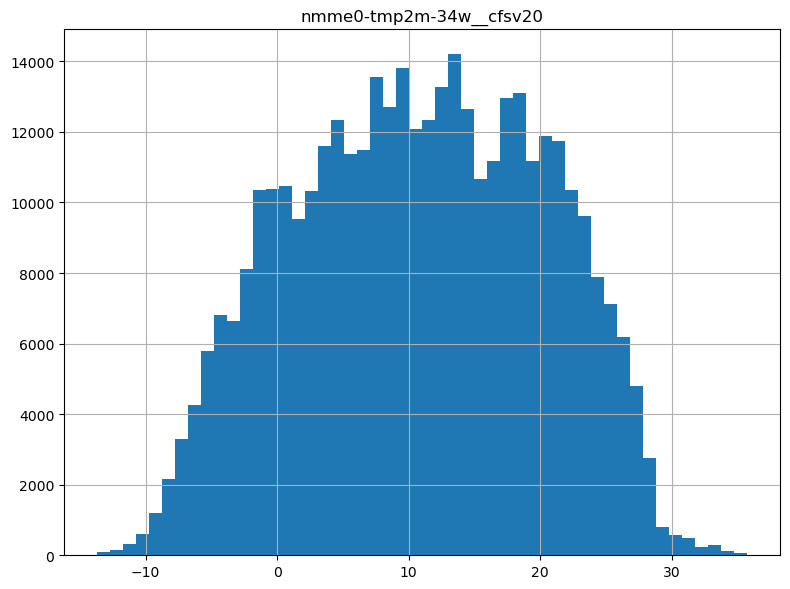

In [28]:
# Plot histograms for all numerical columns
num_cols = cc_train.columns
def plot_histograms(data, column_list):
    """
    This function plots histograms based on the number of columns and data provided.
    
    Parameters
    ----------
    data : pandas dataframe
        The data to be plotted.
    column_list : a list
        The list of 10 numerical column names from the dataset..
    
    Returns
    -------
    void
        Displays histograms from matplotlib.
        The histograms that are being plotted are frequency histograms 
        for the numerical columns specified in the column_list parameter .
    """
    num_cols = column_list
    for col in num_cols:
        plt.figure(figsize=(8, 6))
        data[col].hist(bins=50)
        plt.title(col)
        plt.tight_layout()
        plt.show()
        
plot_histograms(cc_train, num_cols[:10])

###  Data Preproccessing


In [29]:
def location_feature(train, test):
    # Reference: https://www.kaggle.com/code/flaviafelicioni/wids-2023-different-locations-train-test-solved
    scale = 14
    train.loc[:,'lat']=round(train.lat,scale)
    train.loc[:,'lon']=round(train.lon,scale)
    test.loc[:,'lat']=round(test.lat,scale)
    test.loc[:,'lon']=round(test.lon,scale)
    
    train_and_test = pd.concat([train, test], axis=0)
    train_and_test['loc_group'] = train_and_test.groupby(['lat', 'lon']).ngroup()
    print(f'{train_and_test.loc_group.nunique()} unique locations')
    
    train = train_and_test.iloc[:len(train)]
    test = train_and_test.iloc[len(train):].drop(target, axis=1)
    
    return train, test

def cat_encode(train, test):
    # encoding the categorical feature in the train and test data set
    # using OneHotEncoder
    ohe = OneHotEncoder()
    train_encoded = ohe.fit_transform(train[['climateregions__climateregion']])
    test_encoded = ohe.transform(test[['climateregions__climateregion']])
    
    train = train.drop(['climateregions__climateregion'], axis=1)
    test = test.drop(['climateregions__climateregion'], axis=1)
    
    train_encoded = pd.DataFrame(train_encoded.toarray(), columns=ohe.get_feature_names_out(['climateregions__climateregion']))
    test_encoded = pd.DataFrame(test_encoded.toarray(), columns=ohe.get_feature_names_out(['climateregions__climateregion']))
    
    train = pd.concat([train, train_encoded], axis=1)
    test = pd.concat([test, test_encoded], axis=1)
    
    return train, test

def create_new_feat(dataset):
    dataset['year']=pd.DatetimeIndex(dataset['startdate']).year 
    dataset['month']=pd.DatetimeIndex(dataset['startdate']).month 
    dataset['day']=pd.DatetimeIndex(dataset['startdate']).day
    return dataset

def feature_engineering(origin_train, origin_test):
    train, test = origin_train, origin_test
    #train = fill_na_rows(train)
    train = create_new_feat(train)
    test = create_new_feat(test)
    train, test = cat_encode(train, test)
    irrelevant_cols = ['index', 'startdate','contest-tmp2m-14d__tmp2m', 'climateregions__climateregion']
    features = [col for col in train.columns if col not in irrelevant_cols]
    #features = [col for col in train.columns]
    X = train[features]
    X_test = test[features]
    y = train['contest-tmp2m-14d__tmp2m']
    # Initialize the scaler
    scaler = MinMaxScaler()

    # Fit the scaler to the train data
    scaler.fit(X)
    # Transform the train data
    X_train_scaled = scaler.transform(X)

    # Transform the test data
    X_test_scaled = scaler.transform(X_test)
    
    return X, y, X_test

## Splitting the data set to train the model



Target variable: contest-tmp2m-14d__tmp2m

WiDS Datathon Challenge

Definition of target variable:

    the arithmetic mean of the max and min observed temperature over the next 14 days for each location and start date, is provided

Evaluation Metric:

Evaluation Reference

Root Mean Squared Error (RMSE)


In [30]:
target="contest-tmp2m-14d__tmp2m"
cc_test_copy = cc_test.copy()

In [31]:
# Split the data into training and test sets
X, y, X_test = feature_engineering(cc_train.copy(), cc_test.copy())

## Checking Correlation

In [32]:
## Identify correlated features to drop that fall above a correlation threshold 
## https://goodboychan.github.io/python/datacamp/machine_learning/2020/07/08/02-Feature-selection-I-selecting-for-feature-information.html 

def identify_correlated(df, threshold):
    corr_matrix = df.corr().abs()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    reduced_corr_matrix = corr_matrix.mask(mask)
    features_to_drop = [c for c in reduced_corr_matrix.columns if any(reduced_corr_matrix[c] > threshold)]
    return features_to_drop

In [33]:
## choosing 0.85 as a threshold for dropping columns

features_to_drop = identify_correlated(cc_train, .85)

C:\Users\yskon\AppData\Local\Temp\ipykernel_12176\3730249399.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr().abs()


In [34]:
print(len(features_to_drop))
print(features_to_drop)

90
['index', 'nmme0-tmp2m-34w__cancm30', 'nmme0-tmp2m-34w__cancm40', 'nmme0-tmp2m-34w__ccsm30', 'nmme0-tmp2m-34w__ccsm40', 'nmme0-tmp2m-34w__cfsv20', 'nmme0-tmp2m-34w__gfdlflora0', 'nmme0-tmp2m-34w__gfdlflorb0', 'nmme0-tmp2m-34w__gfdl0', 'nmme0-tmp2m-34w__nasa0', 'nmme0-tmp2m-34w__nmme0mean', 'contest-wind-h10-14d__wind-hgt-10', 'nmme-tmp2m-56w__cancm3', 'nmme-tmp2m-56w__cancm4', 'nmme-tmp2m-56w__ccsm3', 'nmme-tmp2m-56w__ccsm4', 'nmme-tmp2m-56w__cfsv2', 'nmme-tmp2m-56w__gfdl', 'nmme-tmp2m-56w__gfdlflora', 'nmme-tmp2m-56w__gfdlflorb', 'nmme-tmp2m-56w__nasa', 'nmme-tmp2m-56w__nmmemean', 'nmme-prate-34w__cancm3', 'nmme-prate-34w__cancm4', 'nmme-prate-34w__ccsm3', 'nmme-prate-34w__ccsm4', 'nmme-prate-34w__cfsv2', 'nmme-prate-34w__gfdl', 'nmme-prate-34w__gfdlflora', 'nmme-prate-34w__gfdlflorb', 'nmme-prate-34w__nasa', 'nmme-prate-34w__nmmemean', 'contest-wind-h100-14d__wind-hgt-100', 'nmme0-prate-56w__cancm30', 'nmme0-prate-56w__cancm40', 'nmme0-prate-56w__ccsm30', 'nmme0-prate-56w__ccsm40'

In [35]:
remove_feature = ['index', 'contest-tmp2m-14d__tmp2m']
features_to_drop_v1 = [ele for ele in features_to_drop if ele not in remove_feature]
features_to_drop_v1

['nmme0-tmp2m-34w__cancm30',
 'nmme0-tmp2m-34w__cancm40',
 'nmme0-tmp2m-34w__ccsm30',
 'nmme0-tmp2m-34w__ccsm40',
 'nmme0-tmp2m-34w__cfsv20',
 'nmme0-tmp2m-34w__gfdlflora0',
 'nmme0-tmp2m-34w__gfdlflorb0',
 'nmme0-tmp2m-34w__gfdl0',
 'nmme0-tmp2m-34w__nasa0',
 'nmme0-tmp2m-34w__nmme0mean',
 'contest-wind-h10-14d__wind-hgt-10',
 'nmme-tmp2m-56w__cancm3',
 'nmme-tmp2m-56w__cancm4',
 'nmme-tmp2m-56w__ccsm3',
 'nmme-tmp2m-56w__ccsm4',
 'nmme-tmp2m-56w__cfsv2',
 'nmme-tmp2m-56w__gfdl',
 'nmme-tmp2m-56w__gfdlflora',
 'nmme-tmp2m-56w__gfdlflorb',
 'nmme-tmp2m-56w__nasa',
 'nmme-tmp2m-56w__nmmemean',
 'nmme-prate-34w__cancm3',
 'nmme-prate-34w__cancm4',
 'nmme-prate-34w__ccsm3',
 'nmme-prate-34w__ccsm4',
 'nmme-prate-34w__cfsv2',
 'nmme-prate-34w__gfdl',
 'nmme-prate-34w__gfdlflora',
 'nmme-prate-34w__gfdlflorb',
 'nmme-prate-34w__nasa',
 'nmme-prate-34w__nmmemean',
 'contest-wind-h100-14d__wind-hgt-100',
 'nmme0-prate-56w__cancm30',
 'nmme0-prate-56w__cancm40',
 'nmme0-prate-56w__ccsm30',
 'n

In [36]:


cc_train_reduced = pd.DataFrame(X.drop(features_to_drop_v1, axis=1))
cc_test_reduced = pd.DataFrame(X_test.drop(features_to_drop_v1, axis=1))
print("Dropped features that are highly correlated")



Dropped features that are highly correlated


In [37]:


X_train, X_test_tts, y_train, y_test = train_test_split(cc_train_reduced, y, test_size=0.33, random_state=42)
print("Split the dataset for training successfully")



Split the dataset for training successfully


## CatBoost Modeling 

In [42]:
'''''
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
import numpy as np

# Set up parameters for CatBoost
params = {'learning_rate': np.linspace(0.05, 0.1, 3),
          'depth': [5, 8],
          'l2_leaf_reg': [5, 7],
          'bagging_temperature': np.linspace(0.25, 0.75, 3),
          'random_strength': np.linspace(0.5, 0.8, 3),
          'n_estimators': [10000, 25000]}

# Set up CatBoost regressor
reg_catb = CatBoostRegressor(eval_metric='RMSE', random_seed=42)

# Perform randomized search to find best parameters
random_search = RandomizedSearchCV(reg_catb, param_distributions=params, n_iter=10, cv=3, n_jobs=-1, verbose=1)
random_search.fit(X_train, y_train)

# Extract the results to a DataFrame
results_df = pd.DataFrame(random_search.cv_results_)

# Save the results to a text file
results_df.to_csv('random_search_results.txt', index=False, sep='\t')

# Print the best parameters found during the randomized search
print("Best parameters:", random_search.best_params_)

'''

Fitting 3 folds for each of 10 candidates, totalling 30 fits


PicklingError: Could not pickle the task to send it to the workers.

In [43]:
params = {'learning_rate': 0.1,
          'depth': 9,
          'l2_leaf_reg': 5,
          'bagging_temperature':0.25,
          'random_strength':0.5,
          'n_estimators': 25000}

from catboost import CatBoostRegressor
reg_catb  = CatBoostRegressor(**params)

reg_catb.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test_tts, y_test)],verbose=100)
y_pred_catb = reg_catb.predict(X_test_tts)

# calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_catb))
print("RMSE:", rmse)

0:	learn: 8.9958882	test: 8.9958882	test1: 8.9908996	best: 8.9908996 (0)	total: 418ms	remaining: 2h 54m 13s
100:	learn: 1.0811791	test: 1.0811791	test1: 1.0853894	best: 1.0853894 (100)	total: 33.8s	remaining: 2h 18m 53s
200:	learn: 0.8017065	test: 0.8017065	test1: 0.8116173	best: 0.8116173 (200)	total: 1m 2s	remaining: 2h 9m 30s
300:	learn: 0.6685807	test: 0.6685807	test1: 0.6828413	best: 0.6828413 (300)	total: 1m 35s	remaining: 2h 10m 35s
400:	learn: 0.5860059	test: 0.5860059	test1: 0.6036937	best: 0.6036937 (400)	total: 2m 6s	remaining: 2h 9m 25s
500:	learn: 0.5287837	test: 0.5287837	test1: 0.5497690	best: 0.5497690 (500)	total: 2m 38s	remaining: 2h 9m 27s
600:	learn: 0.4860867	test: 0.4860867	test1: 0.5098729	best: 0.5098729 (600)	total: 3m 11s	remaining: 2h 9m 23s
700:	learn: 0.4507344	test: 0.4507344	test1: 0.4771052	best: 0.4771052 (700)	total: 3m 44s	remaining: 2h 9m 39s
800:	learn: 0.4230174	test: 0.4230174	test1: 0.4515943	best: 0.4515943 (800)	total: 4m 16s	remaining: 2h 9m 2

Text(0.5, 1.0, 'Feature Importance')

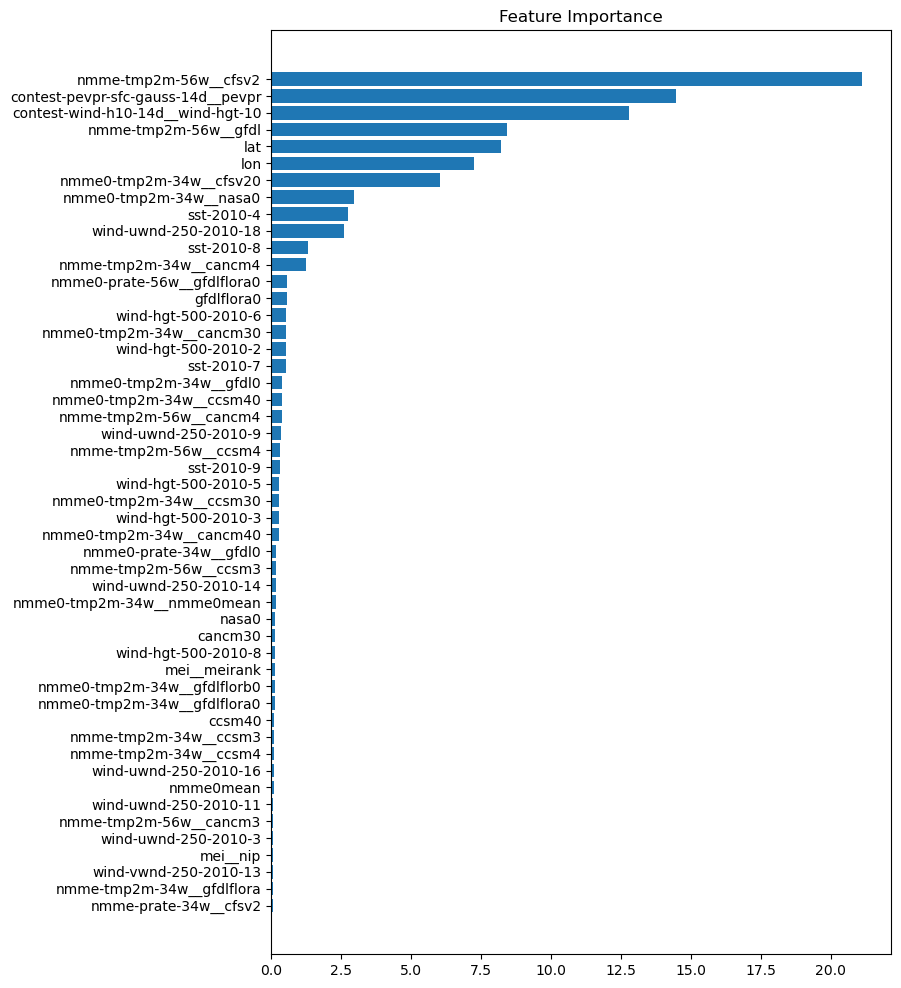

In [49]:
import matplotlib.pyplot as plt
feature_importance = reg_catb.feature_importances_
max_features = 50
sorted_idx = np.argsort(feature_importance)[-max_features:]
fig = plt.figure(figsize=(8, 12))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')

In [44]:
cc_test_copy_v2 = cc_test_copy.copy()
cc_test_pred_catb = reg_catb.predict(X_test)

cc_test_copy_v2[target] = cc_test_pred_catb
cc_test_copy_v2[[target,"index"]].to_csv("catboost.csv",index = False)

## LightGBM

In [ ]:
'''
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# specify the parameters for grid search
params = {'n_estimators': [10000, 15000],
          'max_depth': [6, 8],
          'num_leaves': [31, 40],
          'learning_rate': [0.03, 0.05],
          'min_child_samples': [5, 10],
          'feature_fraction': [0.8,0.9], 
          'bagging_fraction': [0.8,0.9], 
          'bagging_freq': [1,3]}

reg_lgb = lgb.LGBMRegressor(eval_metric='RMSE', random_seed=42)

# perform grid search with cross-validation
grid_search = GridSearchCV(reg_lgb, param_grid=params, cv=3, n_jobs=-1, verbose=3)
grid_search.fit(X_train, y_train)

# print the best hyperparameters found by grid search
print('Best hyperparameters:', grid_search.best_params_)
'''

In [45]:
# parametes removed for now: 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'bagging_freq': 5,
# set up parameters for LightGBM
params = {'boosting_type': 'gbdt',
          'objective': 'regression',
          'metric': 'rmse',
          'max_depth': 8,
          'num_leaves': 40,
          'learning_rate': 0.05,
          #'device_type':'gpu',
          'early_stopping_round': 50,
          'n_estimators': 15000}

reg_lgb = lgb.LGBMRegressor(**params)

reg_lgb.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test_tts, y_test)],
        verbose=100)

# make predictions on the test data
y_pred_lgb = reg_lgb.predict(X_test_tts)

# calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
print("RMSE:", rmse)

c:\Users\yskon\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	training's rmse: 1.29575	valid_1's rmse: 1.30757
[200]	training's rmse: 0.997457	valid_1's rmse: 1.0126
[300]	training's rmse: 0.856194	valid_1's rmse: 0.874666
[400]	training's rmse: 0.76133	valid_1's rmse: 0.782919
[500]	training's rmse: 0.702233	valid_1's rmse: 0.726434
[600]	training's rmse: 0.660295	valid_1's rmse: 0.686948
[700]	training's rmse: 0.626473	valid_1's rmse: 0.655121
[800]	training's rmse: 0.595713	valid_1's rmse: 0.626475
[900]	training's rmse: 0.570046	valid_1's rmse: 0.602715
[1000]	training's rmse: 0.546507	valid_1's rmse: 0.581176
[1100]	training's rmse: 0.525006	valid_1's rmse: 0.561455
[1200]	training's rmse: 0.505294	valid_1's rmse: 0.543387
[1300]	training's rmse: 0.487132	valid_1's rmse: 0.526797
[1400]	training's rmse: 0.472958	valid_1's rmse: 0.514307
[1500]	training's rmse: 0.458685	valid_1's rmse: 0.501507
[1600]	training's rmse: 0.445452	valid_1's rmse: 0.489654
[1700]	training's rmse: 0.433585	valid_1's rmse: 0.479194
[1800]	training's rmse: 0.42

Text(0.5, 1.0, 'Feature Importance')

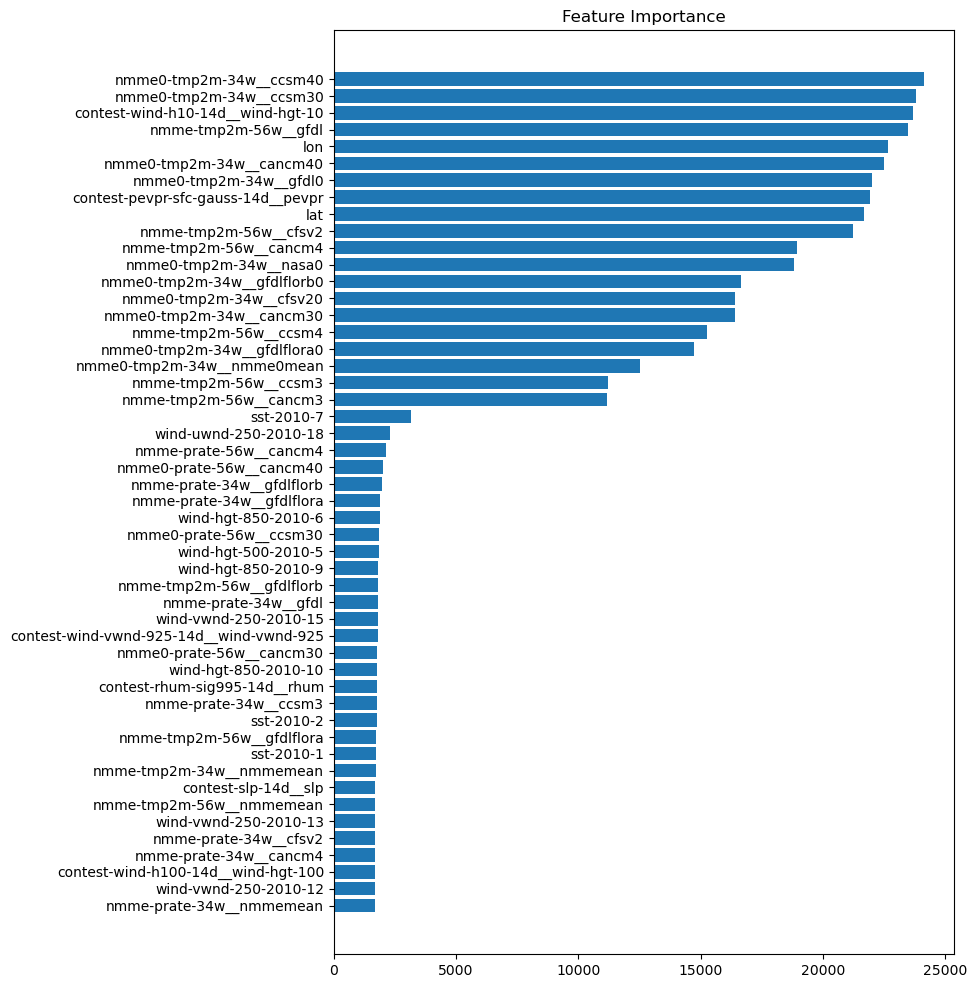

In [50]:
import matplotlib.pyplot as plt
feature_importance = reg_lgb.feature_importances_
max_features = 50
sorted_idx = np.argsort(feature_importance)[-max_features:]
fig = plt.figure(figsize=(8, 12))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')

In [46]:
cc_test_copy_v3 = cc_test_copy.copy()
cc_test_pred_lgb = reg_lgb.predict(cc_test_reduced)
cc_test_copy_v3[target] = cc_test_pred_lgb
cc_test_copy_v3[[target,"index"]].to_csv("lightgbm.csv",index = False)

## Ensemble Catboost + LightGBM

In [47]:
ensemble_preds = cc_test_copy_v2[target]*0.8 + cc_test_copy_v3[target]*0.2

In [48]:
cc_submission = cc_test_copy.copy()
cc_submission[target] = ensemble_preds
cc_submission[[target,"index"]].to_csv('submission.csv', index = False)